# Multiscale time series forecasting

The goal of this notebook is to demonstrate the framework of simultaneous forecasting of multiple multiscale time series. The forecasting procedure includes the following steps:
* time scaling 
* reduction of forecasting to regression
* feature generation
* feature selection
* regression

In [31]:
from __future__ import division
import os

import pandas as pd
from sklearn.linear_model import LinearRegression
from RegressionMatrix import regression_matrix, random_data
from LoadAndSaveData import load_time_series
from Forecasting import frc_class
from collections import namedtuple
tsStruct = namedtuple('tsStruct', 'data request history name readme')

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

# Load your modules

## Loading data
For now, use the default dataset

In [32]:
# see if the data is downloaded yet
load_raw = not os.path.exists(os.path.join("ProcessedData", "EnergyWeather_orig_test.pkl"))

ts_struct = load_time_series.load_all_time_series(datasets='EnergyWeather', load_raw=load_raw, name_pattern="train")[0]
print ts_struct.name
print ts_struct.readme



EnergyWeather_orig_train
Original time energy-weather series


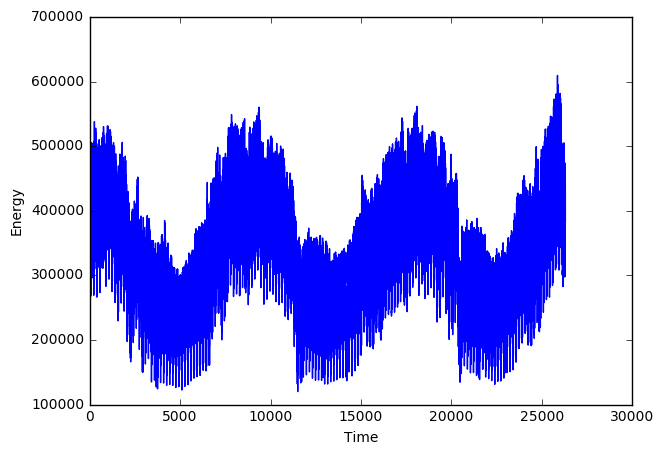

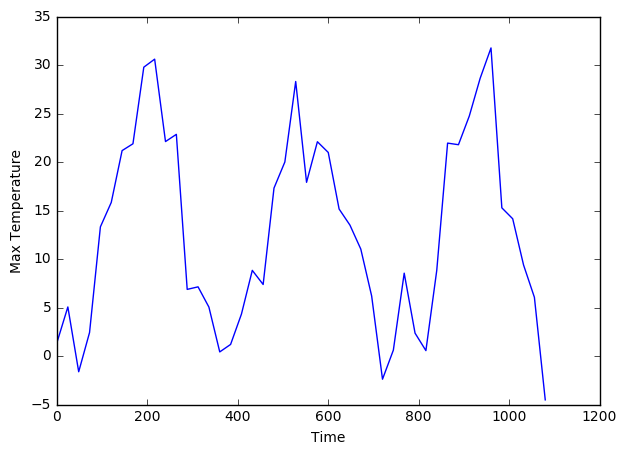

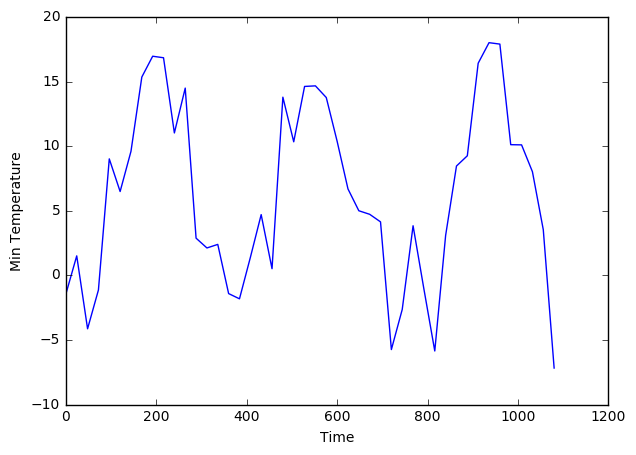

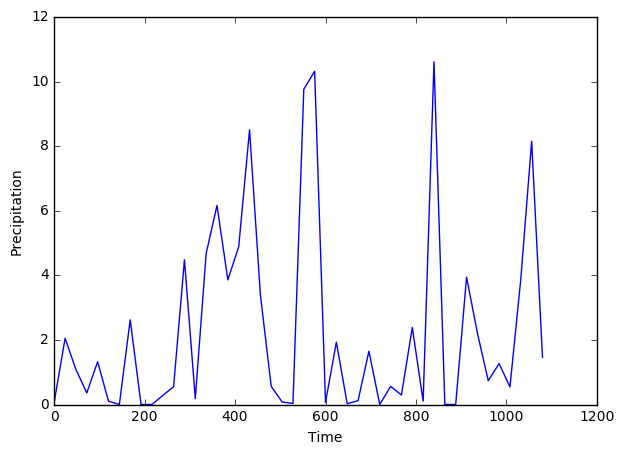

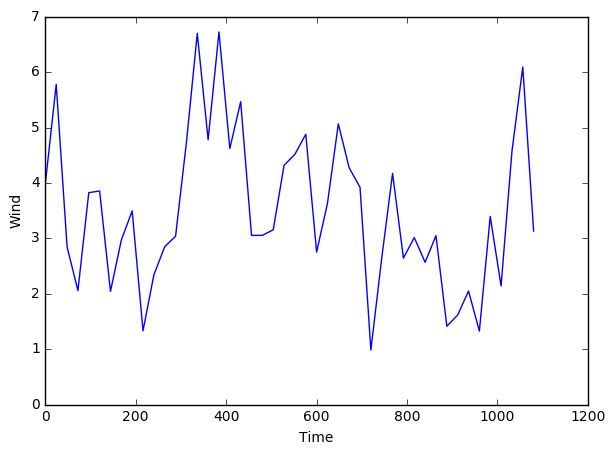

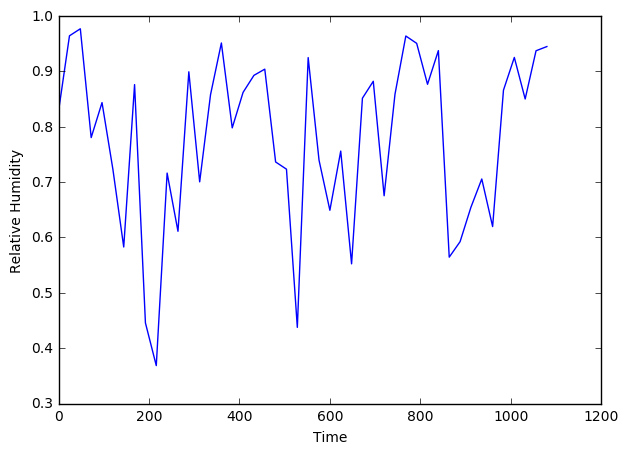

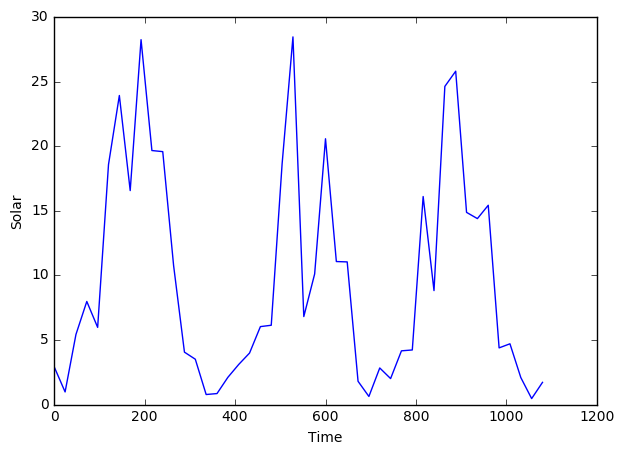

In [33]:
# plot the data
# display.clear_output(wait=True)
for ts in ts_struct.data:
    plt.figure(figsize=(7, 5))
    #plt.title("Time series" + ts_struct.name)
    plt.xlabel("Time")
    plt.ylabel(ts.name)
    plt.plot(ts.T, 'b')
    plt.show()

## Problem statement

Consider a large set of time series $\{\mathbf{s}^{(q)}| \; q = 1,\dots, {Q}\}$, where each real-valued time series $\mathbf s$
$$ \mathbf{s} = [s_1, \dots, s_i, \dots, s_{T}], ~ s_i = s(t_i),\quad 0 \leq t_i \leq t_{\max} $$
is a sequence of observations $s_i = s(t_i)$ of some real-valued signal $s(t)$.

The task is to obtain forecasts $\hat{s}(t_i)$ for  $\Delta t_r <  t_i \leq T_{\max} + \Delta t_r$, given the set $\{\mathbf{s}^{(q)}| \; q = 1,\dots, {Q}\}$

### Time scaling

Each time series $\mathbf{s}^{(q)}$ has its own sampling rate $1/\tau^{(q)}$: $t_i^{(q)} = {i}\cdot\tau^{(q)}.$ Time entries may be uneven. The task is to approximate/resample time series, so that the time entries are evenly placed.

In [34]:
# (Is yet to come)
# For now the time scaling problem is not an issue
# Missing values are imputed inside create_matrix() method.

### Forecasting as regression problem

The design matrix $\mathbf{X}^*$ for the multiscale autoregressive problem statement is constructed  as follows. Let $\mathbf{s}^{(q)}_i$ denote the~$i$-th segment of the time series $\mathbf{s}^{(q)}$
$$
[\mathbf{x}^{(q)}_i | \mathbf{y}^{(q)}_i] =
 \underbrace{s^{(q)}(t_i-\Delta t_r-\Delta t_p),\dots,}_{\mathbf{x}^{(q)}_i} \underbrace{s^{(q)}(t_i-\Delta t_r),\;\dots,s^{(q)}(t_i))}_{\mathbf{y}^{(q)}_i}], $$

where $s^{(q)}(t)$ is an element of time series $\mathbf{s}^{(q)}$.

To construct the design matrix, select $t_i$, $i = 1, \dots, m$ from $\{t_1, \dots, t_T\}$ such that segments $\mathbf{s}_i = [\mathbf{x}_i|\mathbf{y}_i]$ cover time series $\mathbf{s}$ without intersection in target parts  $\mathbf{y}_i$:
$$ |t_{i+1} - t_i| > \Delta t_r. $$
Extract segments $[\mathbf{x}^{(q)}_i | \mathbf{y}^{(q)}_i]$, $i = 1, \dots, m$ from all time series $\mathbf{s}^{(q)}$ and form the matrix $\mathbf{X}^*$.

In [35]:
# create regression matrix X*
data = regression_matrix.RegMatrix(ts_struct)
data.create_matrix(nsteps=1, norm_flag=True)

print data.X.shape, data.Y.shape

Filling NaNs for TS Energy
Filling NaNs for TS Max Temperature
Filling NaNs for TS Min Temperature
Filling NaNs for TS Precipitation
Filling NaNs for TS Wind
Filling NaNs for TS Relative Humidity
Filling NaNs for TS Solar
(1089L, 210L) (1089L, 30L)


### Feature generation and selection
Coming soon...

In [36]:
# # Add some features
# data.generate_features(my_generator) #FIXIT

# # Apply feature transformations
# data.select_features(my_selector) # FIXIT

### Example forecast

In [37]:
# split into train and test
TRAIN_TEST_RATIO = 0.75
data.train_test_split(TRAIN_TEST_RATIO)

model = LinearRegression() # Your model here! The model should have .fit(X) and .predict(X, y) methods
model = data.train_model(model)

data.forecast(model, replace=True) # Now forecasts are available at data.forecasts; first "history" inputs are left zero

# Errors:
train_mae = data.mae(idx_rows=data.idx_train, out=None)
train_mape = data.mape(idx_rows=data.idx_train, out=None)

test_mae = data.mae(idx_rows=data.idx_test, out=None)
test_mape = data.mape(idx_rows=data.idx_test, out=None)

In [38]:
index = [ts.name for ts in ts_struct.data]
res1 = pd.DataFrame(train_mae, index=index, columns=[("MAE", "train")])
res2 = pd.DataFrame(train_mape, index=index, columns=[("MAPE", "train")])
res3 = pd.DataFrame(test_mae, index=index, columns=[("MAE", "test")])
res4 = pd.DataFrame(test_mape, index=index, columns=[("MAPE", "test")])
res = pd.concat([res1, res2, res3, res4], axis=1)
print res

                   (MAE, train)  (MAPE, train)   (MAE, test)  (MAPE, test)
Energy             10252.778084       0.000000  16391.221612      0.000000
Max Temperature        0.065284      -0.004968      0.051339     -0.011358
Min Temperature        0.076219      -0.004934      0.054761     -0.007630
Precipitation          0.110644       0.186404      0.089062      0.061110
Wind                   0.020837       0.006519      0.016768      0.005353
Relative Humidity      0.003357       0.003892      0.002607      0.002759
Solar                  0.186667       0.098263      0.146121      0.085254


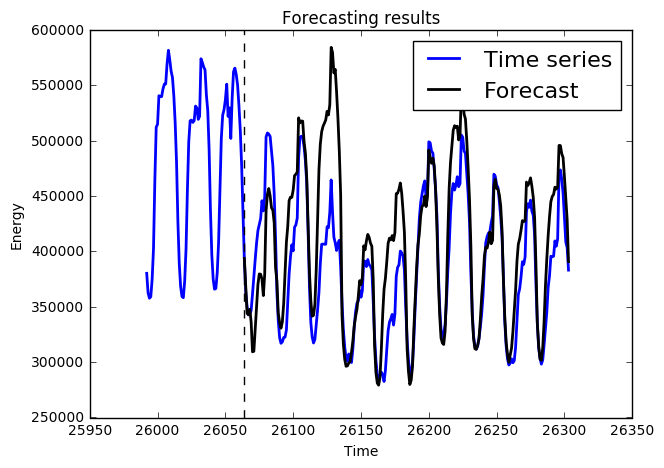

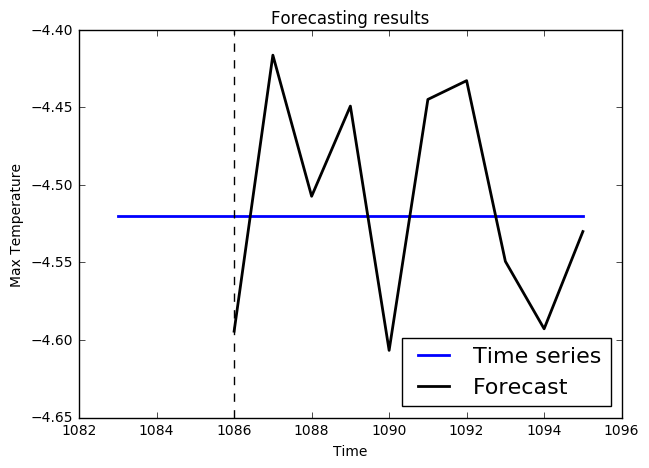

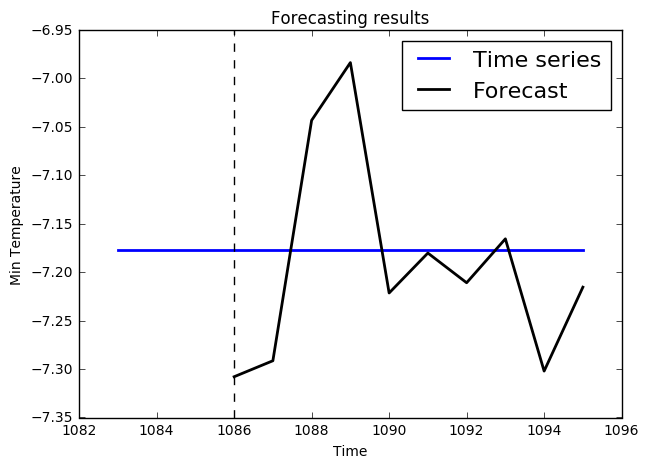

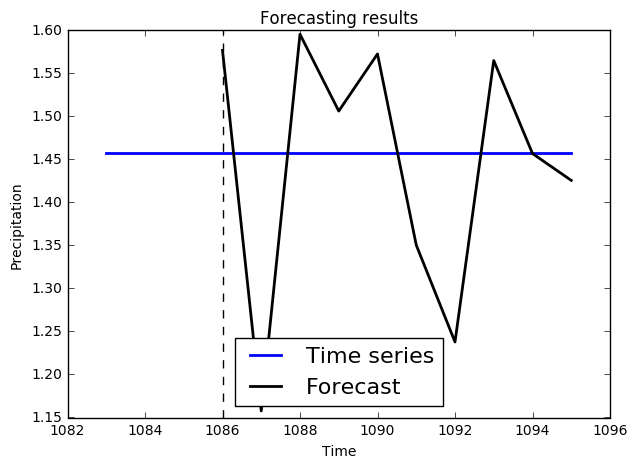

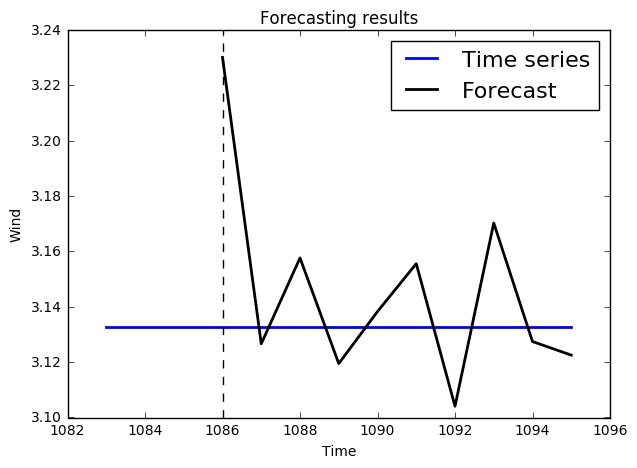

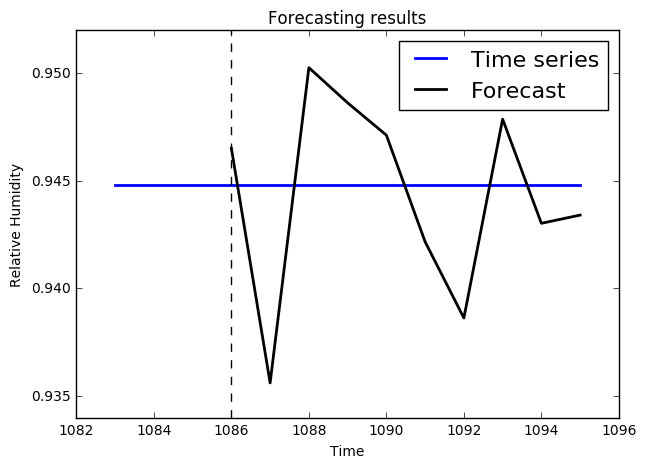

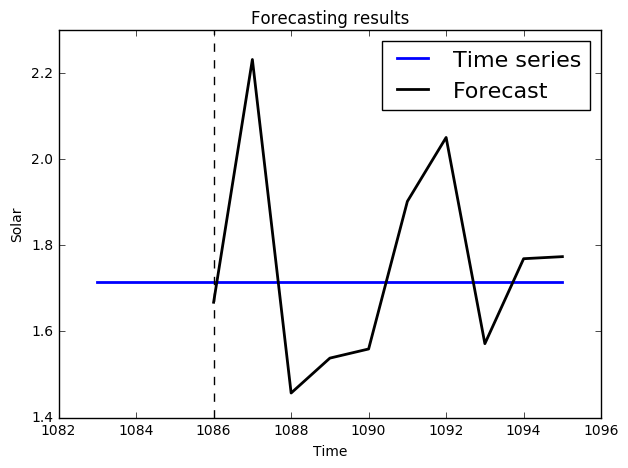

In [39]:
# plot results
data.plot_frc(n_frc=10)